In [1]:
import json
import json_helper as jhlp
import os
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans

In [2]:
plt.style.use('ggplot')

In [3]:
json_path = os.getcwd() + '/database_characterinteractions'
movie_jsons = [os.getcwd() + '/database_characterinteractions/' + json_name for json_name in os.listdir(json_path)]
script_dicts_with_name = {}
for movie_json in movie_jsons:
    with open(movie_json) as f:
        script_dicts_with_name[movie_json.split('/')[-1].split('.')[0]] = json.loads(f.read())

In [4]:
len(movie_jsons)

953

In [5]:
def get_chars_for_scene2(script_dict, scene_id):
    return script_dict[str(scene_id)]

def get_all_char_from_script2(script_dict):
    chars = set()
    for scene in script_dict:
        for char in script_dict[scene]:
            chars.add(char)
    return list(chars)

In [6]:
chars = get_all_char_from_script2(script_dicts_with_name['A Few Good Men'])
print chars
print "\n"
print get_chars_for_scene2(script_dicts_with_name['A Few Good Men'], 10)

[u'LUTHER', u'MCGUIRE', u'SAM', u'HOWARD', u'KAFFEE', u'WEST', u'SPRADLING', u'STONE', u'SERGEANT AT ARMS', u'HAMMAKER', u'JO', u'DOWNEY', u'MARKINSON', u'GIBBS', u'KENDRICK', u'JESSEP', u'DAWSON', u'WHITAKER', u'RANDOLPH', u'ROSS']


[u'KAFFEE', u'SPRADLING', u'KAFFEE', u'SPRADLING', u'KAFFEE', u'SPRADLING', u'KAFFEE']


In [7]:
len(script_dicts_with_name)

952

In [8]:
#graph formation method I
#register a character interaction
#if two characters co-occur in a scen
graphs_I = []
graph_names_I = []
for name in script_dicts_with_name:
    script_dict = script_dicts_with_name[name]
    all_char_list = get_all_char_from_script2(script_dict)
    graph = nx.Graph()
    for scene_id in script_dict:
        scene_chars = get_chars_for_scene2(script_dict, scene_id)
        for i in range(len(scene_chars)-1):
            for j in range(i+1,len(scene_chars)):
                char1 = scene_chars[i]
                char2 = scene_chars[j]
                if char1 == char2:
                    continue
                if not graph.has_edge(char1, char2):
                    graph.add_edge(char1, char2, weight=1)
                else:
                    graph[char1][char2]['weight'] += 1
    graphs_I.append(graph)
    graph_names_I.append(name)

In [9]:
#for graph formation method II
def get_char_interactions_for_scene_new(script_dict, scene_id):
    interactions = []
    chars_in_scene = get_chars_for_scene2(script_dict, scene_id)
    if len(chars_in_scene) < 2: #if a scene has less than two characters
        return interactions
    for i in range(len(chars_in_scene)-1):
        for j in range(i+1, len(chars_in_scene)):
            if j-i > 3:
                continue
            m = j-i
            weight = 4-m
            char1 = chars_in_scene[i]
            char2 = chars_in_scene[j]
            if char1 == char2:
                continue
            interactions.append((char1, char2, weight))
    return interactions

In [10]:
#graph formation method II
#register a character interaction if two characters
#speak within a certain distance of each other
graphs_II = []
graph_names_II = []
for name in script_dicts_with_name:
    script_dict = script_dicts_with_name[name]
    graph = nx.Graph()
    for scene_id in script_dict:
        char_interactions = get_char_interactions_for_scene_new(script_dict, scene_id)
        for interaction in char_interactions:
            char1 = interaction[0]
            char2 = interaction[1]
            wt = interaction[2]
            if not graph.has_edge(char1, char2):
                    graph.add_edge(char1, char2, weight=wt)
            else:
                graph[char1][char2]['weight'] += wt

    graphs_II.append(graph)
    graph_names_II.append(name)

In [11]:
print len(graphs_I)
print len(graph_names_I)
print len(graphs_II)
print len(graph_names_II)

952
952
952
952


In [12]:
def get_graph_metrics(graph):
    try:
        num_chars = len(graph.nodes()) #1
        num_relations = len(graph.edges()) #2
        avg_clustering = nx.average_clustering(graph) #3
        per_node_centrality = sorted(np.array(nx.degree_centrality(graph).values()), reverse=True)
        centralization = sum(per_node_centrality[0] - per_node_centrality)/((num_chars-1)*(num_chars-2)) #4
        sing_char_centrality = (per_node_centrality[0] - per_node_centrality[1])/sum(per_node_centrality) #5
        edge_weights = sorted([float(graph[u][v]['weight'])/5 for u,v in graph.edges()], reverse=True)
        single_relationship_centrality = (edge_weights[0]-edge_weights[1])/sum(edge_weights) #6
        degrees = graph.degree(graph.nodes(), weight='weight').values()
        degrees = np.array(degrees)/sum(edge_weights)
        k = min(10, num_chars)
        top_char_degree_var = np.var(sorted(degrees, reverse=True)[:k]) #7
        k = min(10, len(edge_weights))
        top_relationship_var = np.var(edge_weights[:k]) #8
    except Exception as e:
        return None
    metrics = np.array([num_chars, num_relations, avg_clustering, centralization, sing_char_centrality, 
                       single_relationship_centrality, top_char_degree_var, top_relationship_var])
    if float('inf') in metrics:
        return None
    else:
        return metrics

In [ ]:
movie_names_I = []
movie_features_I = []

for i,graph in enumerate(graphs_I):
    metrics = get_graph_metrics(graph)
    if metrics != None:
        movie_names_I.append(graph_names_I[i])
        movie_features_I.append(metrics)
        
movie_names_II = []
movie_features_II = []

for i,graph in enumerate(graphs_II):
    metrics = get_graph_metrics(graph)
    if metrics != None:
        movie_names_II.append(graph_names_II[i])
        movie_features_II.append(metrics)

In [14]:
print len(movie_names_I)
print len(movie_features_I)

print len(movie_names_II)
print len(movie_features_II)

925
925
925
925


In [15]:
import pandas as pd
feats = [[movie_names_I[i]] + [f for f in mf] for i,mf in enumerate(movie_features_I)]
df = pd.DataFrame(feats)
df

,0,1,2,3,4,5,6,7,8
0,Funny People,18.0,38.0,0.627066,0.038062,0.013158,0.228325,1.114880,7568.6256
1,"Road, The",11.0,28.0,0.832035,0.060000,0.000000,0.236688,1.372372,6195.4324
2,Limitless,19.0,42.0,0.859649,0.046841,0.011905,0.014257,1.287618,709.2756
3,Yes Man,27.0,70.0,0.651552,0.031657,0.107143,0.004606,1.213875,1003.2880
4,"English Patient, The",20.0,49.0,0.601429,0.018775,0.020408,0.104373,0.269430,604.4000
5,Gremlins,23.0,76.0,0.644488,0.032566,0.065789,0.002179,0.763040,18.8484
6,"Crow, The",20.0,56.0,0.500198,0.028932,0.053571,0.045455,0.374572,19.8116
7,Moon,9.0,19.0,0.544444,0.035714,0.000000,0.194133,1.177243,1997.0080
8,Smokin' Aces,26.0,71.0,0.492703,0.013067,0.014085,0.015005,0.021428,192.3796
9,Human Nature,12.0,34.0,0.699074,0.033058,0.000000,0.191882,1.451974,3996.6304


In [16]:
import cPickle as pickle
with open('char_net_final_I.pkl', 'w') as fp:
    pickle.dump(df, fp)

In [17]:
feats = [[movie_names_II[i]] + [f for f in mf] for i,mf in enumerate(movie_features_II)]
df = pd.DataFrame(feats)
df

with open('char_net_final_II.pkl', 'w') as fp:
    pickle.dump(df, fp)

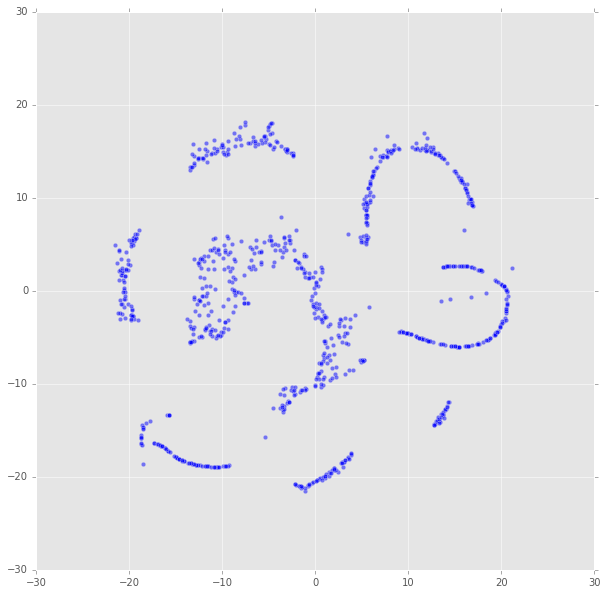

In [18]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0)
tsne_op = tsne_model.fit_transform(movie_features_I)
plt.figure(figsize=(10,10))
plt.scatter(tsne_op[:,0], tsne_op[:,1], alpha=0.5)
plt.show()

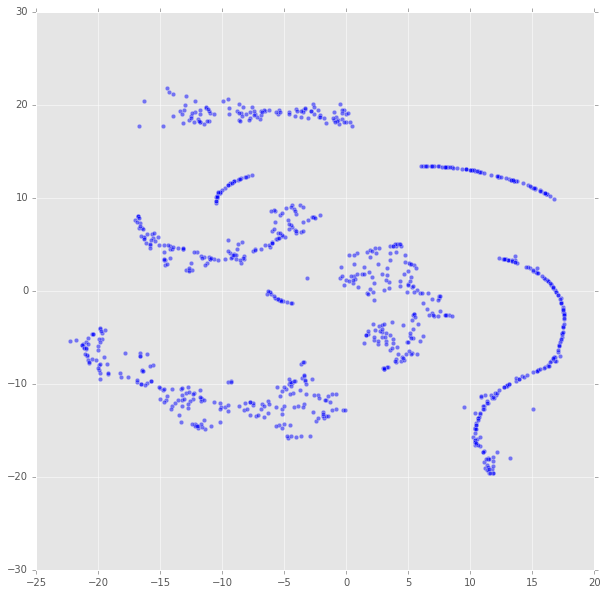

In [19]:
tsne_model = TSNE(n_components=2, random_state=0)
tsne_op = tsne_model.fit_transform(movie_features_II)
plt.figure(figsize=(10,10))
plt.scatter(tsne_op[:,0], tsne_op[:,1], alpha=0.5)
plt.show()

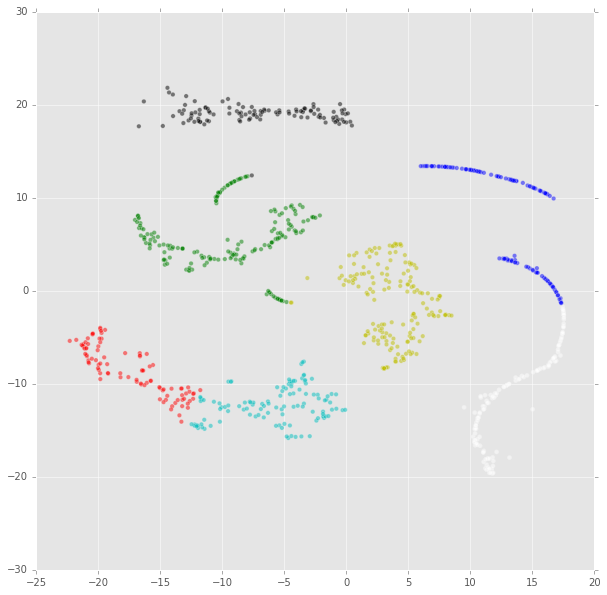

In [20]:
#clustering in tsne reduced dimensions
kmeans = KMeans(n_clusters=7, random_state=0)
tsne_clusters = kmeans.fit_predict(tsne_op)
#c = ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'w']
c = ['r', 'g', 'b', 'y', 'k', 'w', 'c']
#c = np.linspace(0,0.6,7)
colors = [c[t] for t in tsne_clusters]
plt.figure(figsize=(10,10))
plt.scatter(tsne_op[:,0], tsne_op[:,1], c=colors, alpha=0.5)
plt.show()

In [21]:
#lists of movies falling in different clusters
movie_clusters = [[] for _ in range(7)]
for i,tc in enumerate(tsne_clusters):
    movie_clusters[tc].append(movie_names_II[i])
    
for cluster in movie_clusters:
    print cluster[:10]

['Limitless', 'Precious', 'Hudson Hawk', 'Blade Runner', 'Panic Room', 'Watchmen', 'Trainspotting', 'Orphan', "One Flew Over the Cuckoo's Nes", 'Bachelor Party, The']
['Star Trek II: The Wrath of Khan', 'Big White, The', 'Citizen Kane', 'Twiligh', 'Erin Brockovich', 'Matrix, The', 'Family Man, The', "Ocean's Eleven", 'Broken Arrow', 'Angels & Demons']
['Funny People', 'Road, The', 'Human Nature', 'Harold and Kumar Go to White Castle', 'Sideways', 'Rush Hour 2', 'Three Kings (Spoils of War)', 'Paul', 'Up in the Air', 'Fabulous Baker Boys, The']
['Gremlins', 'Crow, The', "Smokin' Aces", 'Eight Legged Freaks', 'Wall-E', 'Dances with Wolves', '1492: Conquest of Paradise', 'Hannibal', 'Pacifier, The', 'Princess Bride, The']
['Yes Man', 'English Patient, The', 'Cold Mountain', 'Crazy, Stupid, Love', "All the King's Men", 'Prophecy, The', 'Men in Black', "All the President's Men", 'Austin Powers - The Spy Who Shagged Me', 'Midnight Cowboy']
['Moon', 'Sherlock Holmes', 'Ginger Snaps', "Cirque 

In [22]:
#find out which cluster the given movie falls in
def get_movie_cluster(name):
    for i,cluster in enumerate(movie_clusters):
        if name in cluster:
            return i

In [23]:
print get_movie_cluster('Terminator')
print get_movie_cluster('Terminator 2: Judgement Day')
print get_movie_cluster('Terminator Salvation')

print get_movie_cluster('Godfather')
print get_movie_cluster('Godfather Part II')
print get_movie_cluster('Godfather Part III, The')

print get_movie_cluster('Kill Bill Volume 1 & 2')
print get_movie_cluster('Reservoir Dogs')

4
1
3
6
5
3
6
1


In [24]:
import cPickle as pickle
with open('movie_data.pkl', 'r') as fp:
    movie_data = pickle.load(fp)

In [25]:
movie_data['ratings'][movie_clusters[0][0]]

7.9

In [26]:
cluster_score_means = []
cluster_score_deviations = []
cluster_genres = []

for cluster in movie_clusters:
    cluster_scores = [movie_data['ratings'][name] for name in cluster if name in movie_data['ratings']]
    cluster_score_means.append(np.mean(cluster_scores))
    cluster_score_deviations.append(np.std(cluster_scores))
    genres = []
    for name in cluster:
        if name in movie_data['genres']:
            genres += movie_data['genres'][name]
    g = set(genres)
    cluster_genres.append(sorted(g, key=lambda m: genres.count(m)))

In [27]:
for i in range(len(movie_clusters)):
    print [g for g in cluster_genres[i] if g != 'genres'][:5]
    print cluster_score_means[i]
    print cluster_score_deviations[i]

[u'Musical', u'Animation', u'Music', u'Sport', u'War']
6.8902173913
1.1401811243
[u'Film-Noir', u'Talk-Show', u'Animation', u'Western', u'Musical']
7.06022099448
0.904969677341
[u'Film-Noir', u'Musical', u'War', u'Sport', u'Music']
7.04344262295
0.865834923967
[u'Short', u'Musical', u'Music', u'Western', u'Sport']
6.74110429448
1.13411840096
[u'Western', u'Documentary', u'Musical', u'Film-Noir', u'Animation']
7.10275229358
0.88757568129
[u'Animation', u'War', u'Film-Noir', u'Short', u'Documentary']
7.01052631579
0.865223093304
[u'War', u'Western', u'Short', u'Sport', u'Music']
6.99736842105
1.01682862037


In [28]:
lls = [[] for _ in range(5)]
lls[0].append(5)
lls[3].append(66)
print lls

[[5], [], [], [66], []]


In [29]:
print graph_names_I.index('Girl with the Dragon Tattoo, The')
print graph_names_II.index('Girl with the Dragon Tattoo, The')

591
591


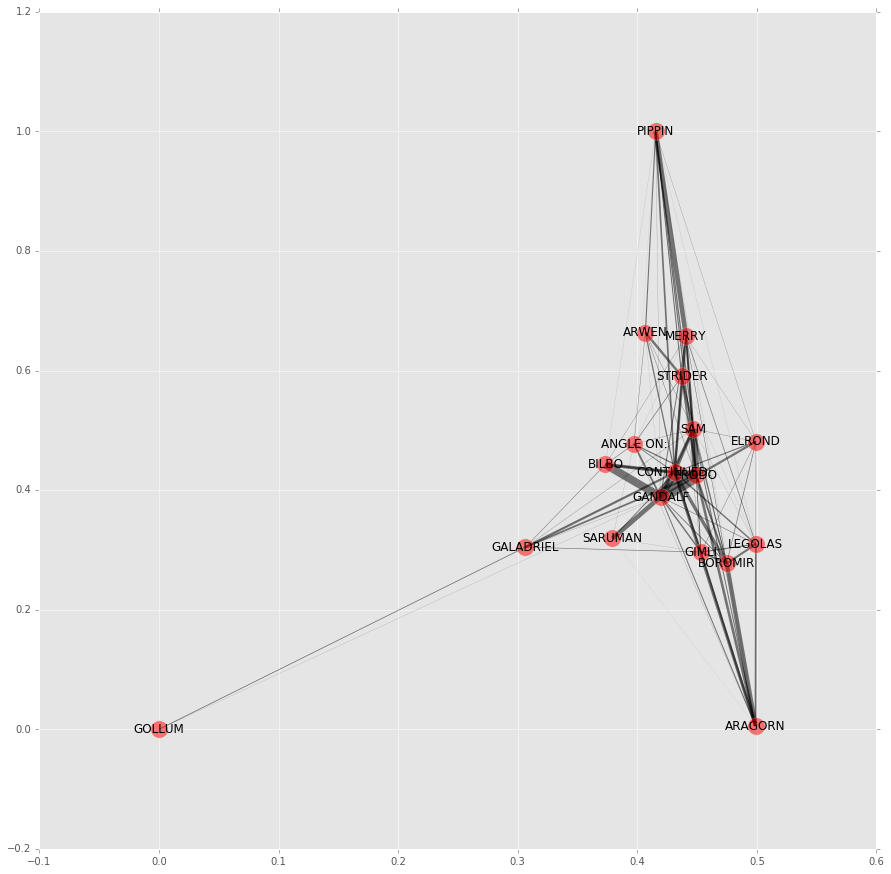

In [30]:
graph_new = graphs_II[graph_names_II.index('Lord of the Rings: Fellowship of the Ring, The')]
graph_new.remove_node('BUTTERBUR')
graph_new.remove_node('FADE TO BLACK')
edge_weights = [float(graph_new[u][v]['weight'])/5 for u,v in graph_new.edges()]
pos = nx.circular_layout(graph_new)
plt.figure(figsize=(15,15))
nx.draw_networkx(graph_new, with_labels=True, width=[e/4 for e in edge_weights], alpha=0.5); plt.show()